[INFO] Device: cpu
[INFO] NPZ: N=789, L=5, C=16, H=10
[INFO] NPZ trial_ids: 2 unique trials
[INFO] NPZ feature_names: 16 features (C=16)
[INFO] Split: window_fallback
[INFO] Train windows: 631 | Val windows (eval set): 158
[INFO] Thresholds: per-horizon best F1 (saved).
[SAVED] eval_outputs\run_20251223_223037\metrics_per_horizon.csv
[SAVED] eval_outputs\run_20251223_223037\predictions_windows.csv
[SAVED] eval_outputs\run_20251223_223037\config_used.json


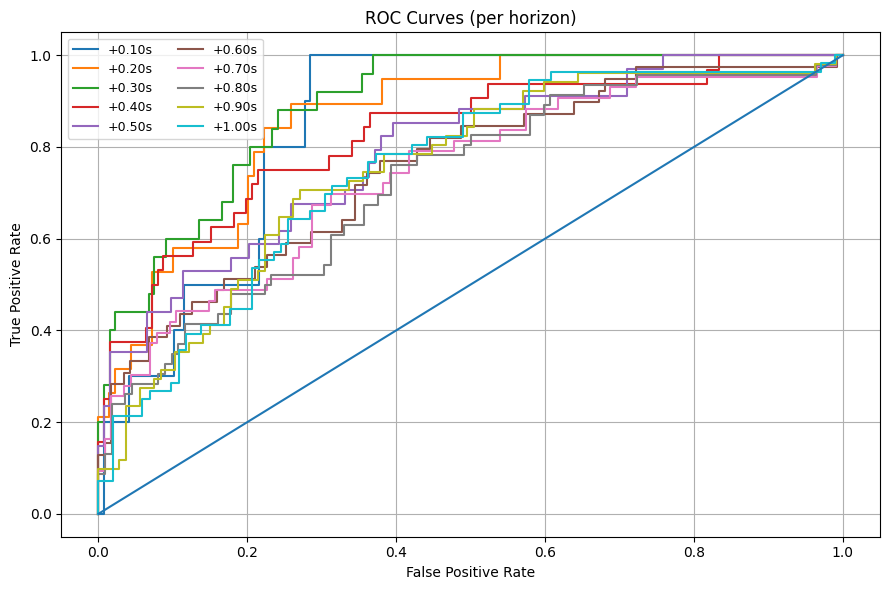

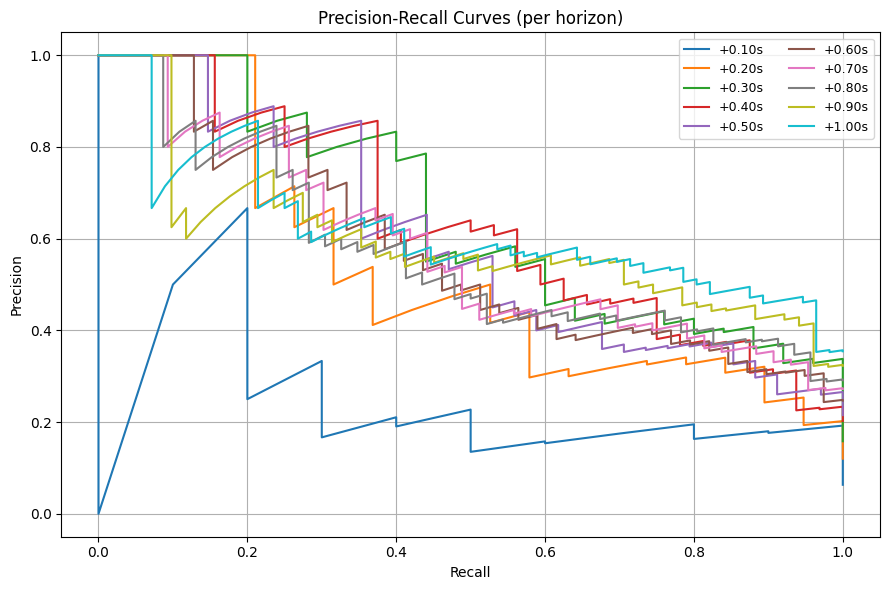

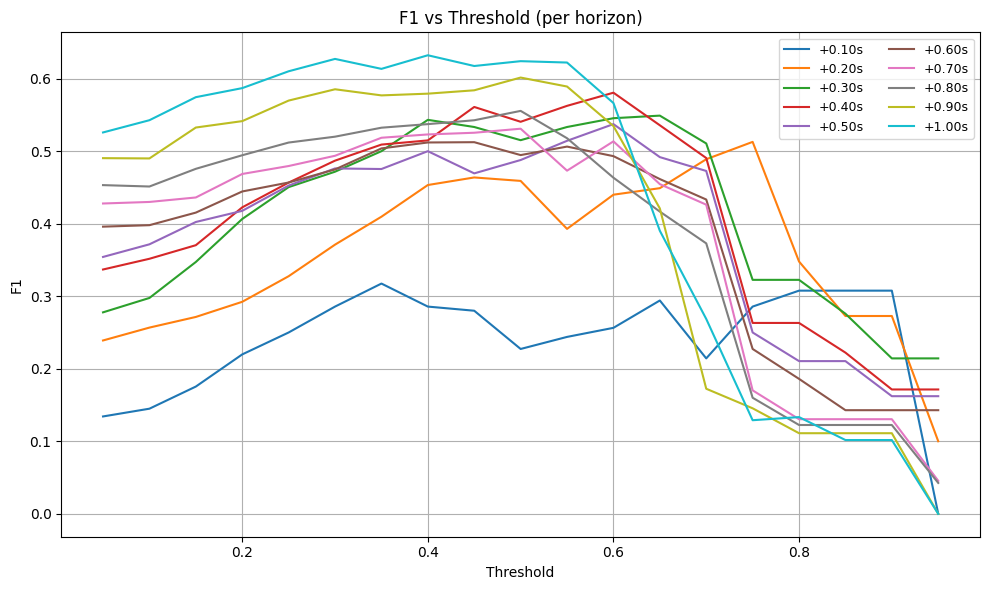

[SAVED] Plots in: eval_outputs\run_20251223_223037\plots

[SUMMARY] Metrics per horizon (val/eval set):
 horizon_sec  roc_auc   pr_auc       f1  precision   recall  balanced_accuracy  threshold_used
         0.1 0.850676 0.283812 0.317460   0.188679 1.000000           0.854730            0.35
         0.2 0.863309 0.536920 0.512821   0.500000 0.526316           0.727187            0.75
         0.3 0.890226 0.652218 0.549020   0.538462 0.560000           0.734887            0.65
         0.4 0.823165 0.633543 0.580645   0.600000 0.562500           0.733631            0.60
         0.5 0.789137 0.598999 0.537313   0.545455 0.529412           0.704222            0.60
         0.6 0.751993 0.576416 0.512397   0.378049 0.794872           0.683150            0.45
         0.7 0.739535 0.581714 0.530973   0.428571 0.697674           0.674924            0.50
         0.8 0.723408 0.568655 0.555556   0.437500 0.760870           0.679542            0.50
         0.9 0.752428 0.596669 0.601504  

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
eval_tcn_multihorizon.py

Evaluate a trained multi-horizon TCN checkpoint on an NPZ dataset.

Inputs
------
- NPZ file with keys (required):
    X            : (N, L, C)
    labels_multi : (N, H)
  and recommended keys:
    horizons     : (H,)
    trial_ids    : (N,)  (object/string)
    feature_names: (C,)  (object/string)

- Checkpoint .pt saved by training script:
    Must contain "state_dict" and model hyperparams (in_channels/out_horizons/etc).
    If it contains split metadata (val_trials or split_mode), we will use it.

Outputs (all saved into a new run folder)
----------------------------------------
eval_outputs/run_YYYYMMDD_HHMMSS/
  config_used.json
  checkpoint_summary.json
  split_summary.csv
  metrics_per_horizon.csv
  thresholds_per_horizon.csv
  confusion_per_horizon.csv
  predictions_windows.csv
  plots/
    roc_curves.png
    pr_curves.png
    f1_vs_threshold.png

Notes
-----
- Evaluation set is the VAL portion of a trial-wise split by default (recommended).
- Thresholding:
    * fixed 0.5  OR
    * per-horizon threshold that maximizes F1 on the evaluation split
"""

import os
import json
import time
import math
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
)

import matplotlib.pyplot as plt


# =========================
# USER CONFIG
# =========================

NPZ_PATH = "tcn_dataset_b_emg_com_future_multihorizon_missteps.npz"
CKPT_PATH = "tcn_multihorizon_best.pt"

OUT_ROOT = "eval_outputs"  # A new timestamped run folder will be created here.

# Split / threshold toggles
SPLIT_MODE = "trial"          # "trial" (recommended) or "window"
TRIAL_SPLIT_FALLBACK_MIN = 5  # if < this many unique trials, fall back to window split
VAL_SPLIT = 0.2
SPLIT_SEED = 42

THRESH_MODE = "per_horizon_best_f1"  # "fixed_0.5" or "per_horizon_best_f1"
FIXED_THRESHOLD = 0.5
THRESH_CANDIDATES = np.linspace(0.05, 0.95, 19)

# Inference
BATCH_SIZE = 256
NUM_WORKERS = 0  # keep 0 for Windows/Jupyter friendliness

# Plot toggles
SAVE_PLOTS = True


# =========================
# MODEL (must match training)
# =========================

class SimpleTCN(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_horizons: int,
        hidden_channels: int = 64,
        num_layers: int = 4,
        kernel_size: int = 3,
        dropout: float = 0.1,
    ):
        super().__init__()
        layers = []
        c_in = in_channels
        for i in range(num_layers):
            dilation = 2 ** i
            padding = (kernel_size - 1) * dilation
            layers.append(
                nn.Sequential(
                    nn.Conv1d(c_in, hidden_channels, kernel_size,
                              padding=padding, dilation=dilation),
                    nn.BatchNorm1d(hidden_channels),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                )
            )
            c_in = hidden_channels
        self.tcn = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_channels, out_horizons)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feat = self.tcn(x)              # (B, hidden, L')
        feat = self.global_pool(feat)   # (B, hidden, 1)
        feat = feat.squeeze(-1)         # (B, hidden)
        logits = self.fc(feat)          # (B, H)
        return logits


class SeqDataset(Dataset):
    """
    X: (N, L, C)
    y: (N, H)
    returns x: (C, L), y: (H,)
    """
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]             # (L, C)
        x = np.transpose(x, (1, 0)) # (C, L)
        y = self.y[idx]             # (H,)
        return torch.from_numpy(x), torch.from_numpy(y)


def get_device():
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")


# =========================
# EVAL HELPERS
# =========================

def make_run_dir(out_root: str) -> str:
    ts = time.strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(out_root, f"run_{ts}")
    plots_dir = os.path.join(run_dir, "plots")
    os.makedirs(plots_dir, exist_ok=True)
    return run_dir


def safe_to_list(x):
    try:
        return x.tolist()
    except Exception:
        try:
            return list(x)
        except Exception:
            return None


def load_npz(npz_path: str):
    data = np.load(npz_path, allow_pickle=True)

    if "X" not in data or "labels_multi" not in data:
        raise ValueError("NPZ must contain keys: 'X' and 'labels_multi'")

    X = data["X"]                       # (N, L, C)
    y = data["labels_multi"]            # (N, H)

    horizons = data["horizons"] if "horizons" in data else np.arange(y.shape[1], dtype=np.float32)

    trial_ids = None
    if "trial_ids" in data:
        trial_ids = data["trial_ids"].astype(str)

    feature_names = None
    if "feature_names" in data:
        # this might be object dtype; force to python strings
        feature_names = np.array([str(v) for v in data["feature_names"]], dtype=object)

    meta = {}
    for k in ["target_fs", "input_window_sec", "stride_sec", "misstep_xlsx", "b_csv_path", "xdf_root_cf", "xdf_root_sd"]:
        if k in data:
            try:
                meta[k] = float(data[k]) if k in ["target_fs", "input_window_sec", "stride_sec"] else str(data[k])
            except Exception:
                meta[k] = str(data[k])

    return X, y, horizons, trial_ids, feature_names, meta


def load_checkpoint(ckpt_path: str, device):
    ckpt = torch.load(ckpt_path, map_location=device)
    if not isinstance(ckpt, dict) or "state_dict" not in ckpt:
        raise ValueError("Checkpoint must be a dict containing 'state_dict' and model metadata.")

    # Required model metadata (fall back to inference if missing)
    in_channels = int(ckpt.get("in_channels", 0))
    out_horizons = int(ckpt.get("out_horizons", 0))

    # Hyperparams
    hidden_channels = int(ckpt.get("hidden_channels", 64))
    num_layers = int(ckpt.get("num_layers", 4))
    kernel_size = int(ckpt.get("kernel_size", 3))
    dropout = float(ckpt.get("dropout", 0.1))

    # Optional split metadata
    split_mode = ckpt.get("split_mode", None)
    split_seed = ckpt.get("split_seed", None)
    val_split = ckpt.get("val_split", None)
    val_trials = ckpt.get("val_trials", None)

    # Optional feature names
    ckpt_feature_names = ckpt.get("feature_names", None)

    return {
        "raw": ckpt,
        "state_dict": ckpt["state_dict"],
        "in_channels": in_channels,
        "out_horizons": out_horizons,
        "hidden_channels": hidden_channels,
        "num_layers": num_layers,
        "kernel_size": kernel_size,
        "dropout": dropout,
        "split_mode": split_mode,
        "split_seed": split_seed,
        "val_split": val_split,
        "val_trials": val_trials,
        "feature_names": ckpt_feature_names,
    }


def build_split(X, y, trial_ids, split_mode, seed, val_split, min_trials_for_trialwise):
    """
    Returns:
      idx_train, idx_val (arrays of indices into X/y)
      split_info dict
    """
    N = X.shape[0]
    any_pos = (y.max(axis=1) > 0).astype(int)

    # If trial_ids missing, must window split
    if trial_ids is None:
        split_mode = "window"

    if split_mode == "trial":
        unique_trials = np.unique(trial_ids)
        n_trials = len(unique_trials)

        if n_trials < min_trials_for_trialwise:
            # fallback to window
            idx = np.arange(N)
            idx_train, idx_val = train_test_split(
                idx, test_size=val_split, random_state=seed, stratify=any_pos
            )
            return idx_train, idx_val, {
                "split_mode_used": "window_fallback",
                "n_unique_trials": int(n_trials),
                "seed": int(seed),
                "val_split": float(val_split),
            }

        # trial-wise split (no stratify here unless you implement trial-level stratify)
        train_trials, val_trials = train_test_split(
            unique_trials, test_size=val_split, random_state=seed
        )
        train_mask = np.isin(trial_ids, train_trials)
        val_mask = np.isin(trial_ids, val_trials)

        idx_train = np.where(train_mask)[0]
        idx_val = np.where(val_mask)[0]

        return idx_train, idx_val, {
            "split_mode_used": "trial",
            "n_unique_trials": int(n_trials),
            "seed": int(seed),
            "val_split": float(val_split),
            "n_train_trials": int(len(train_trials)),
            "n_val_trials": int(len(val_trials)),
            "train_trials": [str(t) for t in train_trials],
            "val_trials": [str(t) for t in val_trials],
        }

    # window-wise split
    idx = np.arange(N)
    idx_train, idx_val = train_test_split(
        idx, test_size=val_split, random_state=seed, stratify=any_pos
    )
    return idx_train, idx_val, {
        "split_mode_used": "window",
        "seed": int(seed),
        "val_split": float(val_split),
    }


def infer_probs(model, device, loader):
    model.eval()
    all_probs = []
    all_y = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device, dtype=torch.float32)
            logits = model(xb)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
            all_y.append(yb.numpy())
    probs_all = np.concatenate(all_probs, axis=0)
    y_all = np.concatenate(all_y, axis=0).astype(int)
    return probs_all, y_all


def find_best_thresholds_per_horizon(y_true, y_prob, horizons, candidates):
    H = y_true.shape[1]
    out = []
    for h_idx in range(H):
        yt = y_true[:, h_idx]
        yp = y_prob[:, h_idx]
        h_sec = float(horizons[h_idx]) if horizons is not None else float(h_idx)

        # If only one class present, threshold search is meaningless
        if yt.max() == 0 or yt.min() == 1:
            out.append({
                "h_idx": h_idx,
                "horizon_sec": h_sec,
                "best_f1_threshold": np.nan,
                "best_f1": np.nan,
                "precision_at_best_f1": np.nan,
                "recall_at_best_f1": np.nan,
                "note": "single_class_in_y_true",
            })
            continue

        best = {"f1": -1.0, "t": 0.5, "p": 0.0, "r": 0.0}
        for t in candidates:
            yhat = (yp >= t).astype(int)
            f1 = f1_score(yt, yhat, zero_division=0)
            if f1 > best["f1"]:
                best["f1"] = f1
                best["t"] = float(t)
                best["p"] = precision_score(yt, yhat, zero_division=0)
                best["r"] = recall_score(yt, yhat, zero_division=0)

        out.append({
            "h_idx": h_idx,
            "horizon_sec": h_sec,
            "best_f1_threshold": best["t"],
            "best_f1": best["f1"],
            "precision_at_best_f1": best["p"],
            "recall_at_best_f1": best["r"],
            "note": "",
        })
    return pd.DataFrame(out)


def compute_metrics_per_horizon(y_true, y_prob, horizons, thresholds_df=None, fixed_threshold=0.5):
    H = y_true.shape[1]
    rows = []
    for h_idx in range(H):
        yt = y_true[:, h_idx]
        yp = y_prob[:, h_idx]
        h_sec = float(horizons[h_idx]) if horizons is not None else float(h_idx)

        # threshold
        if thresholds_df is not None and "best_f1_threshold" in thresholds_df.columns:
            thr = thresholds_df.loc[thresholds_df["h_idx"] == h_idx, "best_f1_threshold"].values
            thr = float(thr[0]) if len(thr) > 0 and np.isfinite(thr[0]) else fixed_threshold
        else:
            thr = fixed_threshold

        # predicted labels
        yhat = (yp >= thr).astype(int)

        # confusion matrix
        # handle missing class by forcing labels=[0,1]
        cm = confusion_matrix(yt, yhat, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()

        # metrics (guard for single-class issues)
        roc_auc = None
        pr_auc = None
        try:
            if len(np.unique(yt)) == 2:
                roc_auc = roc_auc_score(yt, yp)
                pr_auc = average_precision_score(yt, yp)
        except Exception:
            roc_auc = None
            pr_auc = None

        prec = precision_score(yt, yhat, zero_division=0)
        rec = recall_score(yt, yhat, zero_division=0)
        f1 = f1_score(yt, yhat, zero_division=0)
        acc = accuracy_score(yt, yhat)
        try:
            bacc = balanced_accuracy_score(yt, yhat)
        except Exception:
            bacc = np.nan

        rows.append({
            "h_idx": h_idx,
            "horizon_sec": h_sec,
            "threshold_used": thr,
            "roc_auc": np.nan if roc_auc is None else float(roc_auc),
            "pr_auc": np.nan if pr_auc is None else float(pr_auc),
            "accuracy": float(acc),
            "balanced_accuracy": float(bacc) if np.isfinite(bacc) else np.nan,
            "precision": float(prec),
            "recall": float(rec),
            "f1": float(f1),
            "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
            "support_pos": int(yt.sum()),
            "support_total": int(len(yt)),
        })
    return pd.DataFrame(rows)


def save_predictions_csv(path, probs, y_true, horizons, trial_ids_eval, idx_eval_global):
    """
    Save one row per (window, horizon).
    Columns: window_idx_global, window_idx_eval, trial_id, h_idx, horizon_sec, y_true, prob
    """
    N_eval, H = probs.shape
    rows = []
    for i in range(N_eval):
        t_id = "" if trial_ids_eval is None else str(trial_ids_eval[i])
        gidx = int(idx_eval_global[i])
        for h_idx in range(H):
            h_sec = float(horizons[h_idx]) if horizons is not None else float(h_idx)
            rows.append({
                "window_idx_global": gidx,
                "window_idx_eval": i,
                "trial_id": t_id,
                "h_idx": h_idx,
                "horizon_sec": h_sec,
                "y_true": int(y_true[i, h_idx]),
                "prob": float(probs[i, h_idx]),
            })
    pd.DataFrame(rows).to_csv(path, index=False)


def plot_roc_pr_curves(run_dir, y_true, y_prob, horizons):
    plots_dir = os.path.join(run_dir, "plots")
    os.makedirs(plots_dir, exist_ok=True)

    H = y_true.shape[1]
    # ROC curves
    plt.figure(figsize=(9, 6))
    for h_idx in range(H):
        yt = y_true[:, h_idx]
        yp = y_prob[:, h_idx]
        if len(np.unique(yt)) < 2:
            continue
        fpr, tpr, _ = roc_curve(yt, yp)
        h_sec = float(horizons[h_idx]) if horizons is not None else float(h_idx)
        plt.plot(fpr, tpr, label=f"+{h_sec:.2f}s")
    plt.plot([0, 1], [0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (per horizon)")
    plt.grid(True)
    plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "roc_curves.png"), dpi=200)
    plt.show()

    # PR curves
    plt.figure(figsize=(9, 6))
    for h_idx in range(H):
        yt = y_true[:, h_idx]
        yp = y_prob[:, h_idx]
        if len(np.unique(yt)) < 2:
            continue
        prec, rec, _ = precision_recall_curve(yt, yp)
        h_sec = float(horizons[h_idx]) if horizons is not None else float(h_idx)
        plt.plot(rec, prec, label=f"+{h_sec:.2f}s")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves (per horizon)")
    plt.grid(True)
    plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "pr_curves.png"), dpi=200)
    plt.show()


def plot_f1_vs_threshold(run_dir, y_true, y_prob, horizons, candidates):
    plots_dir = os.path.join(run_dir, "plots")
    os.makedirs(plots_dir, exist_ok=True)

    H = y_true.shape[1]
    # One figure that overlays horizons (can get busy, but still useful)
    plt.figure(figsize=(10, 6))
    for h_idx in range(H):
        yt = y_true[:, h_idx]
        yp = y_prob[:, h_idx]
        if len(np.unique(yt)) < 2:
            continue
        f1s = []
        for t in candidates:
            yhat = (yp >= t).astype(int)
            f1s.append(f1_score(yt, yhat, zero_division=0))
        h_sec = float(horizons[h_idx]) if horizons is not None else float(h_idx)
        plt.plot(candidates, f1s, label=f"+{h_sec:.2f}s")
    plt.xlabel("Threshold")
    plt.ylabel("F1")
    plt.title("F1 vs Threshold (per horizon)")
    plt.grid(True)
    plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "f1_vs_threshold.png"), dpi=200)
    plt.show()


# =========================
# MAIN
# =========================

def main():
    device = get_device()
    print("[INFO] Device:", device)

    if not os.path.exists(NPZ_PATH):
        raise FileNotFoundError(f"NPZ not found: {NPZ_PATH}")
    if not os.path.exists(CKPT_PATH):
        raise FileNotFoundError(f"Checkpoint not found: {CKPT_PATH}")

    run_dir = make_run_dir(OUT_ROOT)
    plots_dir = os.path.join(run_dir, "plots")

    # Load NPZ
    X, y, horizons, trial_ids, feature_names, npz_meta = load_npz(NPZ_PATH)
    N, L, C = X.shape
    H = y.shape[1]

    print(f"[INFO] NPZ: N={N}, L={L}, C={C}, H={H}")
    if trial_ids is not None:
        print(f"[INFO] NPZ trial_ids: {len(np.unique(trial_ids))} unique trials")
    if feature_names is not None:
        print(f"[INFO] NPZ feature_names: {len(feature_names)} features (C={C})")

    # Load checkpoint
    ckpt_info = load_checkpoint(CKPT_PATH, device=device)
    ckpt = ckpt_info["raw"]

    # Save checkpoint summary
    ckpt_summary = {
        "ckpt_path": os.path.abspath(CKPT_PATH),
        "in_channels": ckpt_info["in_channels"],
        "out_horizons": ckpt_info["out_horizons"],
        "hidden_channels": ckpt_info["hidden_channels"],
        "num_layers": ckpt_info["num_layers"],
        "kernel_size": ckpt_info["kernel_size"],
        "dropout": ckpt_info["dropout"],
        "split_mode_in_ckpt": ckpt_info["split_mode"],
        "split_seed_in_ckpt": ckpt_info["split_seed"],
        "val_split_in_ckpt": ckpt_info["val_split"],
        "val_trials_in_ckpt_count": None if ckpt_info["val_trials"] is None else len(ckpt_info["val_trials"]),
    }
    with open(os.path.join(run_dir, "checkpoint_summary.json"), "w", encoding="utf-8") as f:
        json.dump(ckpt_summary, f, indent=2)

    # Decide which split to use
    # Priority:
    # 1) If ckpt has val_trials and we have trial_ids -> use those val_trials
    # 2) Else use SPLIT_MODE + seeds defined in this eval script
    split_info = {}
    if trial_ids is not None and ckpt_info["val_trials"] is not None:
        val_trials = np.array([str(t) for t in ckpt_info["val_trials"]], dtype=str)
        val_mask = np.isin(trial_ids.astype(str), val_trials)
        idx_val = np.where(val_mask)[0]
        idx_train = np.where(~val_mask)[0]
        split_info = {
            "split_mode_used": "trial_from_ckpt",
            "n_unique_trials": int(len(np.unique(trial_ids))),
            "n_val_trials": int(len(np.unique(trial_ids[val_mask]))),
            "n_train_trials": int(len(np.unique(trial_ids[~val_mask]))),
            "val_trials": [str(t) for t in np.unique(trial_ids[val_mask])],
        }
        print("[INFO] Split: Using val_trials stored in checkpoint.")
    else:
        idx_train, idx_val, split_info = build_split(
            X, y, trial_ids,
            split_mode=SPLIT_MODE,
            seed=SPLIT_SEED,
            val_split=VAL_SPLIT,
            min_trials_for_trialwise=TRIAL_SPLIT_FALLBACK_MIN,
        )
        print(f"[INFO] Split: {split_info.get('split_mode_used')}")

    print(f"[INFO] Train windows: {len(idx_train)} | Val windows (eval set): {len(idx_val)}")

    # Save split summary
    split_summary_rows = [
        {"key": "split_mode_used", "value": split_info.get("split_mode_used", "")},
        {"key": "seed", "value": split_info.get("seed", "")},
        {"key": "val_split", "value": split_info.get("val_split", "")},
        {"key": "n_windows_total", "value": N},
        {"key": "n_windows_train", "value": len(idx_train)},
        {"key": "n_windows_val", "value": len(idx_val)},
    ]
    if trial_ids is not None:
        split_summary_rows += [
            {"key": "n_unique_trials_total", "value": int(len(np.unique(trial_ids)))},
            {"key": "n_unique_trials_train", "value": int(len(np.unique(trial_ids[idx_train])))},
            {"key": "n_unique_trials_val", "value": int(len(np.unique(trial_ids[idx_val])))},
        ]
    pd.DataFrame(split_summary_rows).to_csv(os.path.join(run_dir, "split_summary.csv"), index=False)

    # Build model from checkpoint metadata (preferred)
    # If ckpt metadata missing, fall back to NPZ shapes
    in_channels = ckpt_info["in_channels"] if ckpt_info["in_channels"] > 0 else C
    out_horizons = ckpt_info["out_horizons"] if ckpt_info["out_horizons"] > 0 else H

    model = SimpleTCN(
        in_channels=in_channels,
        out_horizons=out_horizons,
        hidden_channels=ckpt_info["hidden_channels"],
        num_layers=ckpt_info["num_layers"],
        kernel_size=ckpt_info["kernel_size"],
        dropout=ckpt_info["dropout"],
    ).to(device)
    model.load_state_dict(ckpt_info["state_dict"])
    model.eval()

    # Prepare eval (val) loader
    X_val = X[idx_val]
    y_val = y[idx_val]
    val_ds = SeqDataset(X_val, y_val)
    val_loader = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False,
        num_workers=NUM_WORKERS,
    )

    # Inference
    probs_val, y_true_val = infer_probs(model, device, val_loader)

    # Threshold selection
    thresholds_df = None
    if THRESH_MODE == "per_horizon_best_f1":
        thresholds_df = find_best_thresholds_per_horizon(
            y_true_val, probs_val, horizons=horizons, candidates=THRESH_CANDIDATES
        )
        thresholds_df.to_csv(os.path.join(run_dir, "thresholds_per_horizon.csv"), index=False)
        print("[INFO] Thresholds: per-horizon best F1 (saved).")
    elif THRESH_MODE == "fixed_0.5":
        thresholds_df = None
        # still save a simple thresholds file for clarity
        pd.DataFrame([{
            "h_idx": i,
            "horizon_sec": float(horizons[i]),
            "threshold_used": float(FIXED_THRESHOLD),
            "mode": "fixed_0.5"
        } for i in range(H)]).to_csv(os.path.join(run_dir, "thresholds_per_horizon.csv"), index=False)
        print("[INFO] Thresholds: fixed 0.5 (saved).")
    else:
        raise ValueError(f"Unknown THRESH_MODE: {THRESH_MODE}")

    # Metrics
    metrics_df = compute_metrics_per_horizon(
        y_true_val, probs_val, horizons=horizons,
        thresholds_df=thresholds_df,
        fixed_threshold=FIXED_THRESHOLD,
    )
    metrics_df.to_csv(os.path.join(run_dir, "metrics_per_horizon.csv"), index=False)

    # Confusion-only CSV (sometimes convenient)
    conf_df = metrics_df[["h_idx", "horizon_sec", "threshold_used", "tn", "fp", "fn", "tp", "support_pos", "support_total"]].copy()
    conf_df.to_csv(os.path.join(run_dir, "confusion_per_horizon.csv"), index=False)

    # Save predictions (long format)
    trial_ids_val = trial_ids[idx_val] if trial_ids is not None else None
    save_predictions_csv(
        os.path.join(run_dir, "predictions_windows.csv"),
        probs=probs_val,
        y_true=y_true_val,
        horizons=horizons,
        trial_ids_eval=trial_ids_val,
        idx_eval_global=idx_val,
    )

    # Save config used
    config_used = {
        "NPZ_PATH": os.path.abspath(NPZ_PATH),
        "CKPT_PATH": os.path.abspath(CKPT_PATH),
        "OUT_DIR": os.path.abspath(run_dir),
        "SPLIT_MODE": SPLIT_MODE,
        "TRIAL_SPLIT_FALLBACK_MIN": TRIAL_SPLIT_FALLBACK_MIN,
        "VAL_SPLIT": VAL_SPLIT,
        "SPLIT_SEED": SPLIT_SEED,
        "THRESH_MODE": THRESH_MODE,
        "FIXED_THRESHOLD": FIXED_THRESHOLD,
        "THRESH_CANDIDATES": safe_to_list(THRESH_CANDIDATES),
        "BATCH_SIZE": BATCH_SIZE,
        "npz_meta": npz_meta,
        "feature_names": None if feature_names is None else [str(x) for x in feature_names],
        "horizons": safe_to_list(horizons),
        "split_info": split_info,
    }
    with open(os.path.join(run_dir, "config_used.json"), "w", encoding="utf-8") as f:
        json.dump(config_used, f, indent=2)

    print(f"[SAVED] {os.path.join(run_dir, 'metrics_per_horizon.csv')}")
    print(f"[SAVED] {os.path.join(run_dir, 'predictions_windows.csv')}")
    print(f"[SAVED] {os.path.join(run_dir, 'config_used.json')}")

    # Plots
    if SAVE_PLOTS:
        plot_roc_pr_curves(run_dir, y_true_val, probs_val, horizons)
        plot_f1_vs_threshold(run_dir, y_true_val, probs_val, horizons, THRESH_CANDIDATES)
        print(f"[SAVED] Plots in: {plots_dir}")

    # Quick console summary
    print("\n[SUMMARY] Metrics per horizon (val/eval set):")
    show_cols = ["horizon_sec", "roc_auc", "pr_auc", "f1", "precision", "recall", "balanced_accuracy", "threshold_used"]
    print(metrics_df[show_cols].to_string(index=False))


if __name__ == "__main__":
    main()
